In [1]:
import sys
from pathlib import Path

sys.path.insert(0, "/share/home/ychi/dev/sperm_struct/notebooks")

import h2 as h
import pandas as pd
from lib.plot import plot_chrom_position

In [2]:
lr_contour = pd.read_pickle(
    h.fig1 / "Fig1_contour" / f"Sperm_hg.lr_contour.v{h.version}.pkl"
    )
dv_contour = pd.read_pickle(
    h.fig1 / "Fig1_contour" / f"Sperm_hg.dv_contour.v{h.version}.pkl"
    )

In [3]:
batches = [
    "Sperm_hg",
    "Sperm_Liu",
    "Sperm_Zheng"
]

arg_bfs_lr_ss_files = { # single slice
    batch : (h.ddir / batch).with_suffix(".lr_ss.bfs.pkl")
    for batch in batches
}

arg_bfs_dv_ss_files = {
    batch : (h.ddir / batch).with_suffix(".dv_ss.bfs.pkl")
    for batch in batches
}

arg_bfs_lr_ft_files = { # full thickness
    batch : (h.ddir / batch).with_suffix(".lr_ft.bfs.pkl")
    for batch in batches
}
arg_bfs_dv_ft_files = { # full thickness
    batch : (h.ddir / batch).with_suffix(".dv_ft.bfs.pkl")
    for batch in batches
}
arg_bfs_voxel_files = {
    batch : (h.ddir / batch).with_suffix(".voxel.bfs.pkl")
    for batch in batches
}

In [4]:
from hic_basic.plot.utils import filling_l2r_plotly
from plotly.subplots import make_subplots

from hic_basic.data import chromosomes

GRCh38 = chromosomes("GRCh38").index

In [5]:
# def plot_chom_position(orig_bfs, chroms, title, contour,
#                        rows=3, cols=7, minCells=80):
#     bfs = orig_bfs.copy()
#     fig = make_subplots(
#         rows = rows,
#         cols = cols,
#         subplot_titles=chroms,
#         vertical_spacing=0.1
#     )
#     valid_cells = bfs.notna().sum(axis=1)
#     # if minCells < 1: # treat as quantile
#     #     minCells = valid_cells.quantile(minCells)
#     # bfs = bfs.loc[valid_cells > minCells]
#     for row, col, i, chrom in filling_l2r_plotly(rows, cols, chroms):
#         #print(row, col, i, chrom)
#         chrom_dist = bfs[chrom + "_dist"].mean(axis=1).copy()
#         chrom_dist.loc[~contour] = pd.NA
#         chrom_dist = chrom_dist.unstack(fill_value=pd.NA)
#         subfig = plot_figure(
#             chrom_dist
#         )
#         fig.add_trace(
#             subfig.data[0],
#             row = row,
#             col = col
#         )
#     fig.update_traces(
#         showscale = False
#     )
#     fig.update_layout(
#         height = 600,
#         width = 900,
#         title = title,
#         plot_bgcolor = "rgba(0,0,0,0)"
#     )
#     fig.update_xaxes(
#         visible = False
#     )
#     fig.update_yaxes(
#         visible = False
#     )
#     return fig

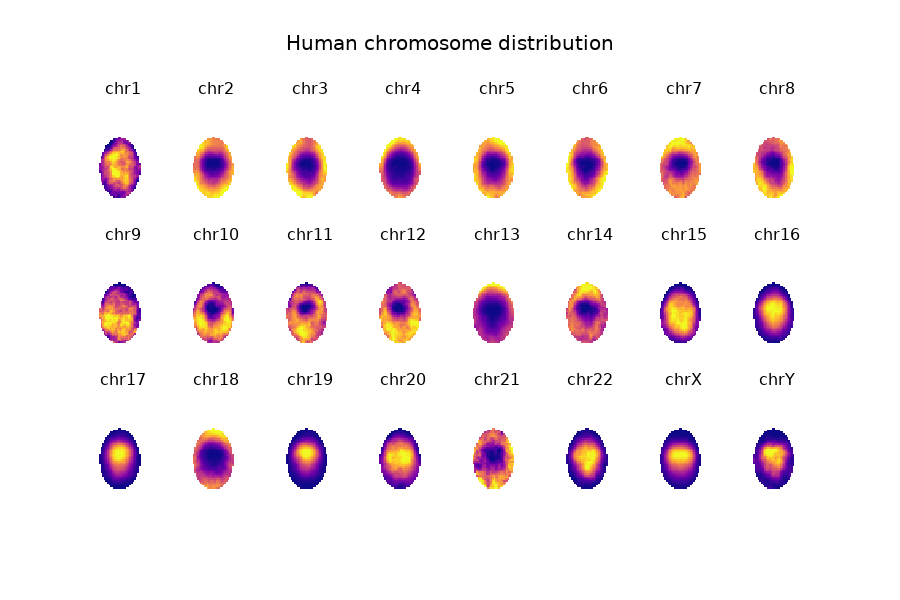

In [14]:
bfs = pd.read_pickle(arg_bfs_lr_ss_files["Sperm_hg"])
if h.version == "0":
    fig = plot_chrom_position(
        bfs,
        GRCh38,
        "human chromosome distribution (lr; count; slice)",
        lr_contour,
        rows = 3,
        cols = 8,
        #minCells=80
        normL=chromosomes("GRCh38")["length"]
        )
elif h.version in ["1","2"]:
    fig = plot_chrom_position(
        bfs,
        GRCh38,
        #(lr; ratio; slice)
        "Human chromosome distribution",
        lr_contour,
        rows = 3,
        cols = 8,
        #zmin = 0,
        #zmax = 0.1,
        normL=None,
        ratio=True,
        t_filt = 0.02,
        cmap = "Plasma",
        #showscale = True
        showscale = False,
        #minCells=80
        )
    fig.update_layout(
        template = h.template
    )
    #fig.write_image("output/human_sperm_chrom_position.pdf")
    fig.write_image("output/human_sperm_chrom_position_separate_scale.pdf")
else:
    raise NotImplementedError(f"version {h.version} not implemented")
fig.show(renderer="png")
#fig.show()

In [ ]:
def plot_chrom_position_chr13(orig_bfs, chroms, title, 
    contour, minCells=80, normL=None,
    rows=3, cols=7, showscale=False, ratio=False, t_filt=False, threshold=0, **args
    ):
    bfs = orig_bfs.copy()
    if normL is not None:
        normL = normL / normL.median()
    fig = make_subplots(
        rows = rows,
        cols = cols,
        subplot_titles=chroms,
        vertical_spacing=0.04,
        horizontal_spacing=0.01
    )
    valid_cells = bfs.notna().sum(axis=1)
    # if minCells < 1: # treat as quantile
    #     minCells = valid_cells.quantile(minCells)
    # bfs = bfs.loc[valid_cells > minCells]
    for row, col, i, chrom in filling_l2r_plotly(rows, cols, chroms):
        candidate_cols = [
            chrom + "_dist",
            chrom + "(pat)_dist",
            chrom + "(mat)_dist"
        ]
        use_cols = [ # multi index
            col
            for col in bfs.columns
            if col[0] in candidate_cols
        ]
        # for diploid, this result in mean of the two homologs
        if ratio:
            # calculate ratio
            chrom_dist = bfs.loc[
                :,
                use_cols
                ].T.groupby(
                    level=0
                ).apply(
                    lambda x : x.droplevel(0) / bfs["density"].T
                ).T.mean(axis=1).copy()
        else:
            chrom_dist = bfs.loc[
                :,
                use_cols
                ].mean(axis=1).copy()
        if normL is not None:
            chrom_dist = chrom_dist / normL[chrom]
        if contour is not None:
            chrom_dist.loc[~contour] = pd.NA
        chrom_dist = chrom_dist.unstack(fill_value=pd.NA)
        # subfig = plot_figure_canvas(
        #     chrom_dist,
        #     square_size = 52,
        #     step = 2 ,
        #     **args
        # )
        if t_filt:
            # --- pick min, max z value ---
            chrom_dist_long = chrom_dist.stack().reset_index(drop=True)
            zmin, zmax = chrom_dist_long.quantile([threshold, 1-threshold])
            default_args = {
                "zmin" : zmin,
                "zmax" : zmax
            }
            args = {**default_args, **args}
        subfig = plot_figure(
            chrom_dist,
            **args
        )
        fig.add_trace(
            subfig.data[0],
            row = row,
            col = col
        )
    fig.update_traces(
        showscale = False
    )
    if showscale:
        # show only one colorbar
        fig.update_traces(
            row = 2,
            col = 2,
            showscale = True
        )
    fig.update_layout(
        height = 600,
        width = 900,
        title = title,
        plot_bgcolor = "rgba(0,0,0,0)"
    )
    fig.update_xaxes(
        visible = False
    )
    fig.update_yaxes(
        visible = False
    )
    return fig

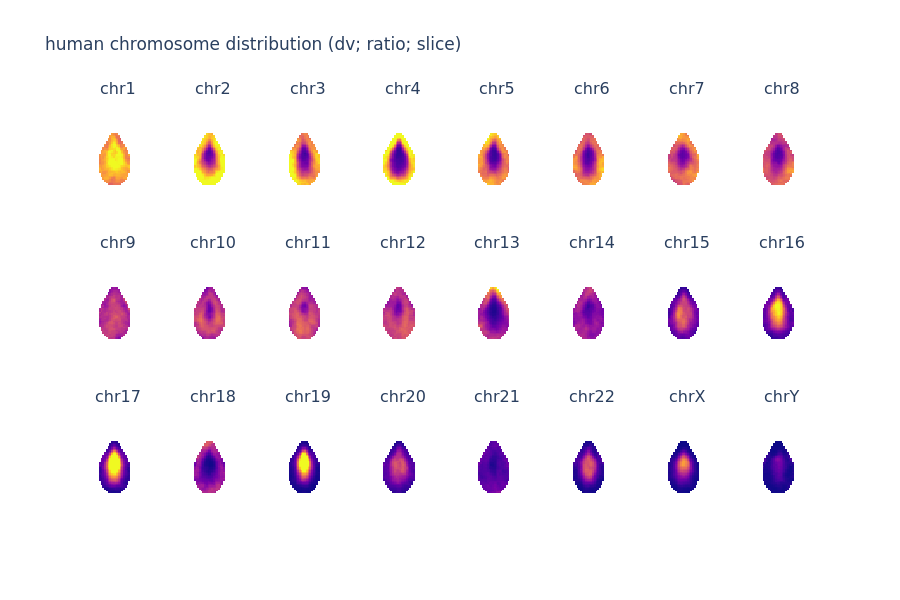

In [10]:
bfs = pd.read_pickle(arg_bfs_dv_ss_files["Sperm_hg"])
if h.version == "0":
    fig = plot_chrom_position(
        bfs,
        GRCh38,
        "chromosome distribution of all sperms",
        dv_contour,
        rows = 3,
        cols = 8
        #minCells=80
        )
elif h.version == "1":
    fig = plot_chrom_position(
        bfs,
        GRCh38,
        "human chromosome distribution (dv; ratio; slice)",
        dv_contour,
        rows = 3,
        cols = 8,
        zmin = 0,
        zmax = 0.1,
        normL=None,
        ratio=True
        #minCells=80
        )
fig.show(renderer="png")

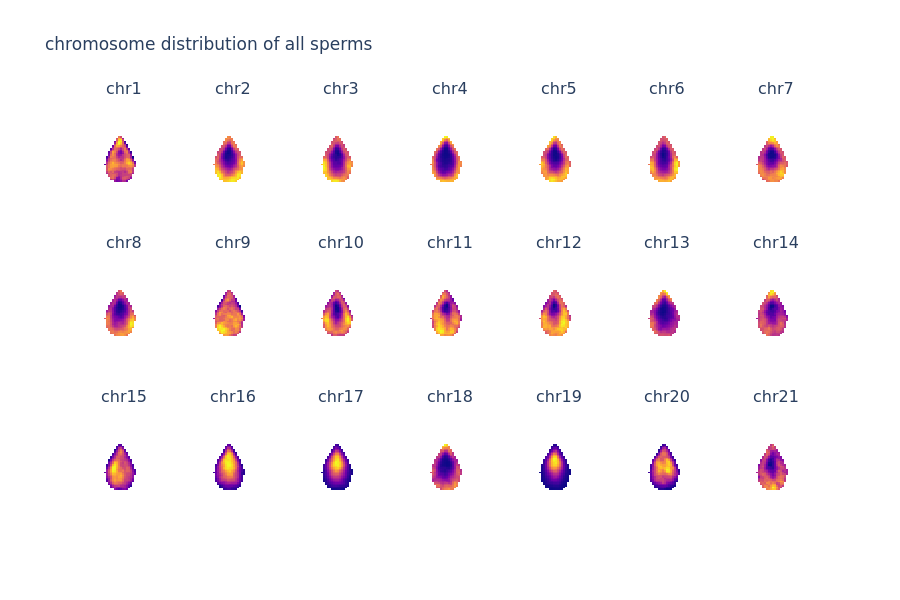

In [21]:
bfs = pd.read_pickle(arg_bfs_dv_ss_files["Sperm_hg"])
fig = plot_chom_position(
    bfs,
    GRCh38,
    "chromosome distribution of all sperms",
    dv_contour,
    #minCells=80
    )
fig.show(renderer="png")

### distribution of different person

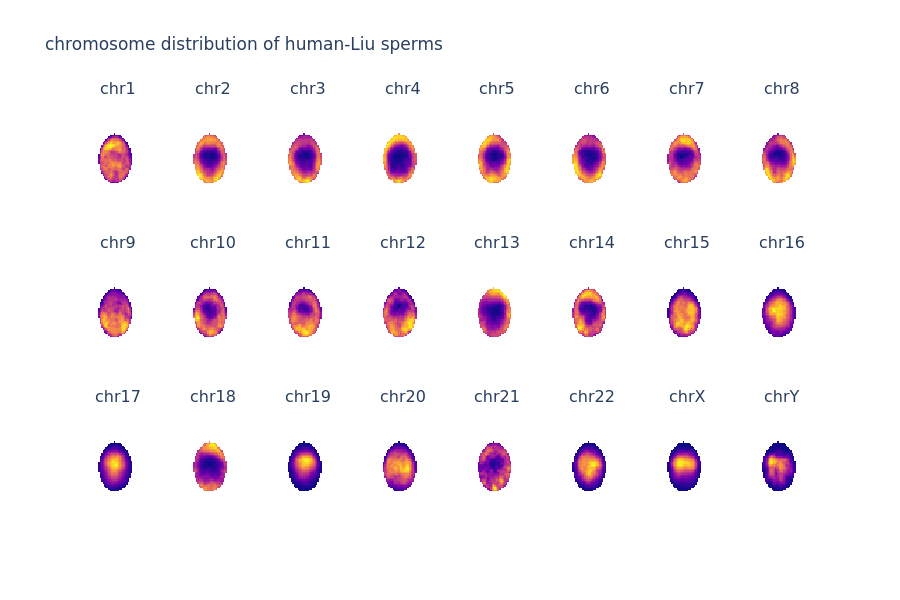

In [7]:
#bfs = pd.read_pickle(arg_bf_lr_cs_files["tillsperm25"])
#bfs = bfs.loc[-5:5].groupby(level=(1,2), observed=False).sum(min_count=1)
bfs = pd.read_pickle(arg_bfs_lr_ss_files["Sperm_Liu"])
fig = plot_chom_position(
    bfs,
    GRCh38,
    "chromosome distribution of human-Liu sperms",
    lr_contour,
    rows = 3,
    cols = 8
    #minCells=80
    )
fig.show(renderer="png")
#fig.show()

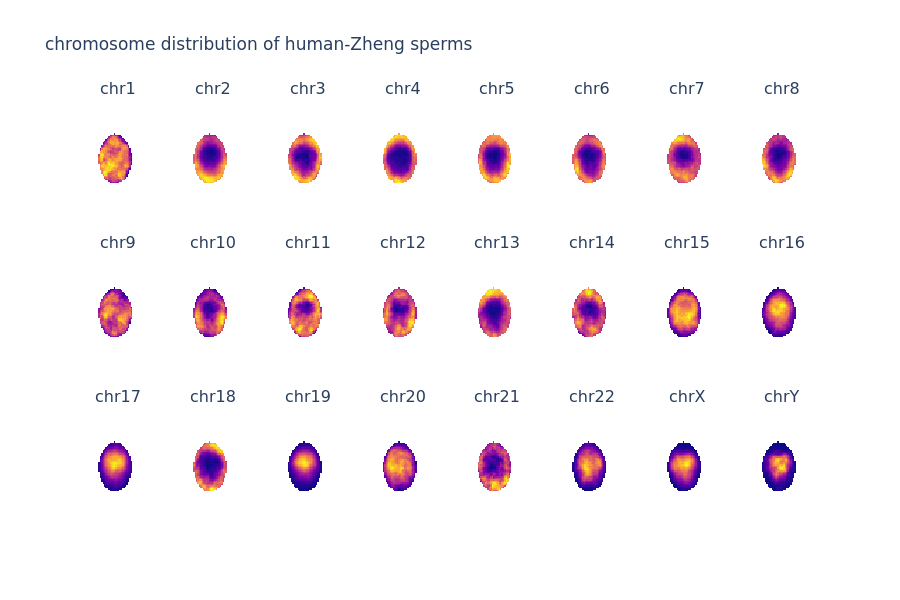

In [9]:
#bfs = pd.read_pickle(arg_bf_lr_cs_files["tillsperm25"])
#bfs = bfs.loc[-5:5].groupby(level=(1,2), observed=False).sum(min_count=1)
bfs = pd.read_pickle(arg_bfs_lr_ss_files["Sperm_Zheng"])
fig = plot_chom_position(
    bfs,
    GRCh38,
    "chromosome distribution of human-Zheng sperms",
    lr_contour,
    rows = 3,
    cols = 8
    #minCells=80
    )
fig.show(renderer="png")
#fig.show()

### embedding of human chromosomes

In [5]:
def prepare_design_matrix(bfs, chroms):
    dist_rows = [f"{chrom}_dist" for chrom in chroms]
    design_matrix = bfs.T.groupby(
        level=0
    ).mean().loc[dist_rows]
    # drop full-na columns
    print(design_matrix.shape)
    design_matrix = design_matrix.dropna(
        axis=1, how="all"
        )
    print(design_matrix.shape)
    # fill na with 0
    design_matrix = design_matrix.fillna(0)
    # normalize withing each entry
    design_matrix = design_matrix.div(
        design_matrix.mean(axis=1),
        axis=0
    )
    design_matrix = design_matrix.rename(
        index = {f"{chrom}_dist" : chrom for chrom in chroms}
    )
    return design_matrix

In [6]:
from hic_basic.data import chromosomes
chroms = chromosomes("GRCh38").index
chroms = [i for i in chroms if i not in ["chrX","chrY"]]

In [7]:
Liu_bfs = pd.read_pickle(arg_bfs_lr_ss_files["Sperm_Liu"])
Zheng_bfs = pd.read_pickle(arg_bfs_lr_ss_files["Sperm_Zheng"])
Sperm_hg = pd.read_pickle(arg_bfs_lr_ss_files["Sperm_hg"])
Sperm_hg_voxel = pd.read_pickle(arg_bfs_voxel_files["Sperm_hg"])

In [9]:
Liu_dsgn_m = prepare_design_matrix(Liu_bfs, chroms)
Liu_dsgn_m = Liu_dsgn_m.rename(
    index = {chrom : f"m1_{chrom}" for chrom in chroms}
)
Zheng_dsgn_m = prepare_design_matrix(Zheng_bfs, chroms)
Zheng_dsgn_m = Zheng_dsgn_m.rename(
    index = {chrom : f"m2_{chrom}" for chrom in chroms}
)
Sperm_hg_voxel_dsgn_m = prepare_design_matrix(
    Sperm_hg_voxel,
    chroms
    )

(22, 3996)
(22, 1273)
(22, 3996)
(22, 1448)
(22, 6048)
(22, 1403)


In [10]:
# do PCA on design_matrix
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components=10)
pca_samples = pca.fit_transform(Sperm_hg_voxel_dsgn_m)
pca_samples = pd.DataFrame(
    pca_samples,
    index = Sperm_hg_voxel_dsgn_m.index,
    columns = [f"PC{i}" for i in range(1, n_components+1)]
)

In [11]:
import seaborn as sns

NameError: name 'plt' is not defined

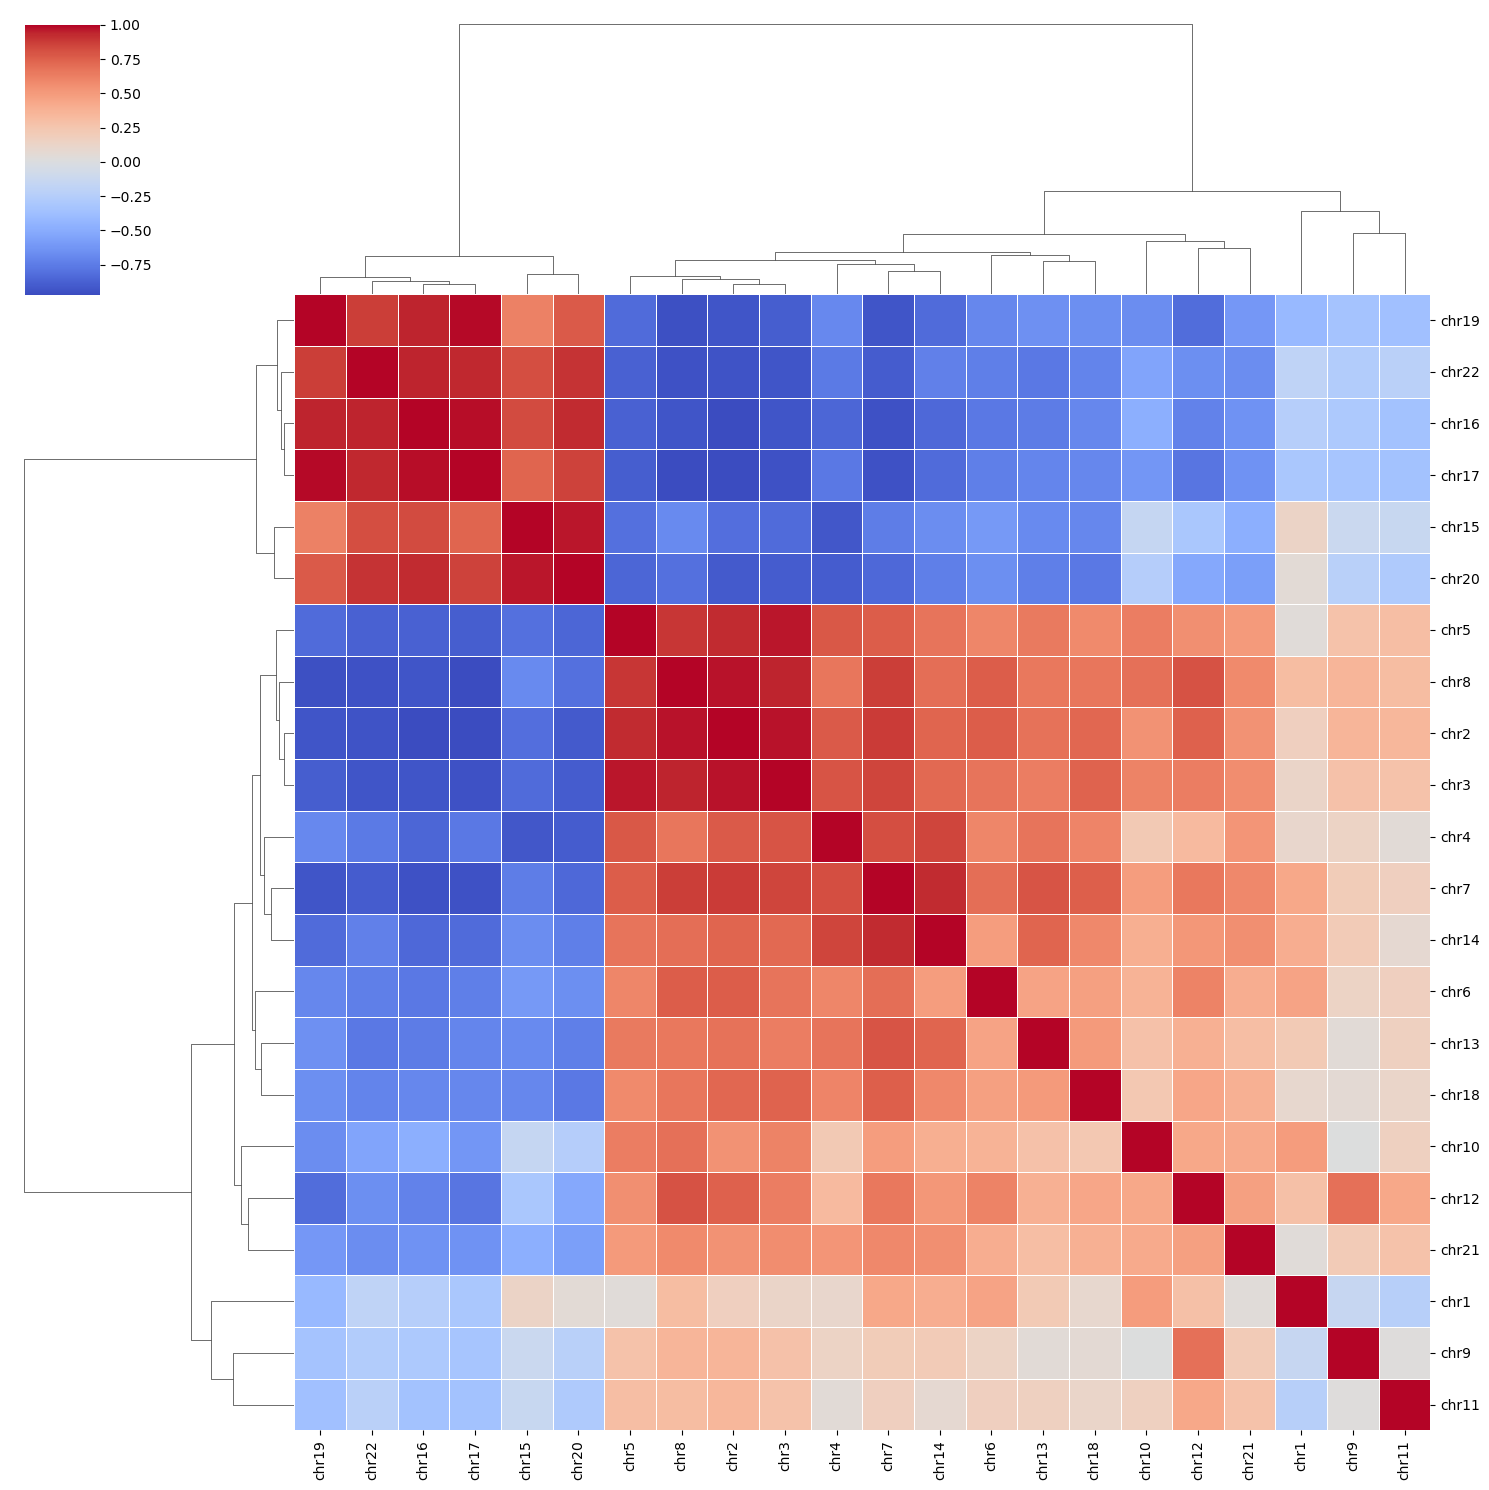

In [12]:
sns.clustermap(pca_samples.T.corr(), 
               method='average',  # 聚类时使用的方法，如'average'、'single'或'complete'
               metric='euclidean',  # 计算距离时使用的度量
               cmap='coolwarm',  # 热图颜色映射
               linewidths=.5,  # 热图线宽
               figsize=(15, 15))  # 图片尺寸

plt.show()